## Our ML Process -

    Step 01 - Load Dataset
    Step 02 - EDA -  Check for NaN values, Univariate analysis, Impute Missing values
    Step 03 - Basic ML Tasks - X, y split, Train - Test Split, One Hot (for X Train), Feature Scaling 
    Step 04 - Run a Baseline Model - Logistic Regression
    Step 05 - Feature Selection Chi2 (with K values ranging from 10-49)
    Step 06 - Run Logistic Regression compare with previous models
    Step 07 - Feature Importance with Random Forest
    Step 08 - Run Logistic Regression compare with previous models
    Step 09 - SMOTE
    Step 10 - Run Logistic Regression with SMOTE compare with previous models

### Import required Library 

In [35]:
import pandas as pd, numpy as np # for data manipulation and linear algebra
import matplotlib.pyplot as plt, seaborn as sns # data visualization libs
from sklearn.model_selection import train_test_split # performs train test split
from sklearn.metrics import roc_auc_score # AUC score metric
from sklearn.feature_selection import SelectKBest, chi2 # chi2 test 
from sklearn.ensemble import RandomForestClassifier # RFC for model training and feature importance
from sklearn.tree import DecisionTreeClassifier # Decision Tree classifier
from sklearn.linear_model import LogisticRegression # Linear Model for classification
from sklearn.preprocessing import StandardScaler # Standard scaler for continous variables
from imblearn.over_sampling import SMOTE # Tool for Oversampling 

%matplotlib inline

In [27]:
df = pd.read_csv('bank-additional/modified1.csv', sep=',', index_col=0) # Read CSV file to df pandas dataframe 
df['y'] = np.where(df['y']=='yes',1,0) # Encode y target as 0 & 1
df.drop(['duration'],axis=1,inplace=True) # Drop Duration feature as it is biased
df.head() # displays head of dataframe

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,Unskilled,married,Basic,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,Service,married,Mid,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,Service,married,Mid,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,Service,married,Basic,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,Service,married,Mid,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Custom ML Workflow API

In [28]:
def xy_split(df, target='y'):
    '''
    Creates X matrix and y vector from df dataframe
    return X, y
    '''
    X = df.drop([target], axis=1)
    y = df[target]
    return X, y
    
def tt_split(X, y, test_size=0.5, random_state=42):
    '''
    Performs train test split 
    returns X_train, X_test, y_train, y_test
    '''
    X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

def run_model(X_train, X_test, y_train, y_test, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_scores[:,1])
    return auc

def con_cat_split(X, con_cols, cat_cols):
    '''
    Performs dataframe splits based on the continous & 
    categorical column lists passed as arguments
    
    returns con_df & cat_df
    '''
    con_df = X[con_cols]
    cat_df = X[cat_cols]
    return con_df, cat_df

def chi2_test(cat_df, X, y, k=10):
    '''
    Performs chi2 feature importance/significance test
    takes categorical variables as input 
    returns chi2_df
    '''
    Xd = pd.get_dummies(X)
    cat_df_oh = pd.get_dummies(cat_df)
    skb = SelectKBest(chi2,k=k)
    skb.fit(cat_df_oh, y)
    chi2_df = Xd[cat_df_oh.columns[skb.get_support()]]
    
    chi2_test_df = pd.DataFrame(skb.scores_,columns=['chi2 score'])
    chi2_test_df['pvals'] = skb.pvalues_
    chi2_test_df.sort_values(by='pvals',ascending=True)

    return chi2_df, chi2_test_df

def oversample(X_train, y_train):
    '''
    Performs oversampling using SMOTE on train data
    returns oversampled X_res, y_res
    '''
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(X_train, y_train)
    return X_res, y_res

def scale(Xd, cols_transform = ['emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']):
    '''
    Performs Standard Scaler given dataframe with continous variables as list
    returns Xd - (Scaled Dataframe)
    '''
    ss = StandardScaler()
    ss.fit_transform(Xd[cols_transform])    
    Xd.loc[:, cols_transform] = ss.fit_transform(Xd.loc[:, cols_transform])
    return Xd

### Execute Custom ML-Workflow APIs

In [29]:
# X y split
X, y = xy_split(df, target='y')
# One Hot Encode 
Xd = pd.get_dummies(X)
# Standard Scaling 
Xd = scale(Xd)
# Train Test split
X_train, X_test, y_train, y_test = tt_split(Xd, y)

###  Logistic Regression, Decision Tree, RandomForest before SMOTE

In [39]:
models = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier]

for model in models:
    # run model
    model = model()
    auc = run_model(X_train, X_test, y_train, y_test, model) # train and returns AUC test score
    print('AUC Score = %.2f' %(auc*100) +' %\nOn Model - \n'+str(model))

AUC Score = 79.36 %
On Model - 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
AUC Score = 62.21 %
On Model - 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
AUC Score = 74.21 %
On Model - 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fra

### Oversample using SMOTE

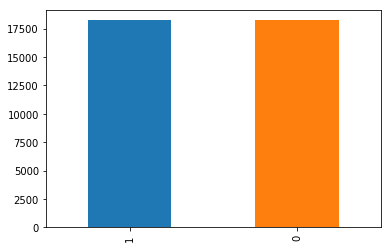

In [40]:
yr = pd.DataFrame(y_res,columns=['y'])
yr['y'].value_counts().plot.bar()

In [33]:
# Oversample using SMOTE
X_res, y_res = oversample(X_train, y_train)

# Models as list
models = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier]

# Run each model
for model in models:
    # run model
    model = model()
    auc = run_model(X_res, X_test, y_res, y_test, model) # train and returns AUC test score
    print('AUC Score = %.2f' %(auc*100) +' %\nOn Model - \n'+str(model))

AUC Score = 78.96 %
On Model - 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
AUC Score = 61.65 %
On Model - 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
AUC Score = 73.63 %
On Model - 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fra

## Feature Importance

### Using Chi2

In [92]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')

In [119]:
cat_cols = ['age', 'job', 'marital', 'education', 'default', 
            'housing', 'loan','contact', 'month', 'day_of_week', 
            'poutcome']

con_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
           'euribor3m', 'nr.employed']
con_df, cat_df = con_cat_split(X, con_cols, cat_cols)

In [138]:
# chi2 test
chi2_df, chi2_test_df = chi2_test(cat_df, X, y, k=35)

In [136]:
# Top 10 values with most significant Chi2 scores
chi2_test_df.sort_values(by=['pvals'])[:10]

,chi2 score,pvals
53,3982.548056,0.000000e+00
41,842.916583,2.520714e-185
44,763.644573,4.331272e-168
45,645.541017,2.083806e-142
35,547.958309,3.500598e-121
9,355.864620,2.239058e-79
6,335.662863,5.616159e-75
42,321.423320,7.093710e-72
26,321.320431,7.469382e-72
34,315.310771,1.521738e-70


In [41]:
# No. of columns used for prediction
len(X_train.columns)

50

### Conclusion -

    In this project we aimed to build a model to predict whether the client will subscribe to a term deposit and identify the main attributes that affect the subscription.

    We developed a bunch of linear & nonlinear models. Then, we assessed them using test accuracy measurement and AUC. Logistic Regression was the most powerful classifier with 79.36% AUC.

    In summary, firstly, it is more likely that clients would subscribe to a term deposit if the conversation on the phone is long (at least 5 minutes).
    
    Conversion rate of person called on Cell Phone is higher than that of Landline.
    
    Divided Jobs & Education in buckets since there were multiple levels, this also helped us in imputing the missing values.